In [1]:
import os
import json
import torch
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
from datasets import find_padding_masks

In [2]:
transformer_model = TransformerEncoder(feat_dim=35,
                                    max_len=40,
                                    d_model=64, 
                                    n_heads=8, 
                                    num_layers=1,
                                    dim_feedforward=256, 
                                    dropout=0.1, 
                                    freeze=False)
transformer_model.float()

# Load pretrained weights 
transformer_model.load_state_dict(torch.load('../models/inputting_unity_norm.pt'))

<All keys matched successfully>

In [3]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 35 * 40, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        logits = self.fc2(x)
        return logits

In [4]:
cnn_model = CNNModel()
cnn_model

CNNModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=89600, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)

In [5]:
class CombinedModel(nn.Module):
    def __init__(self, transformer_model, cnn_model):
        super(CombinedModel, self).__init__()
        self.transformer_model = transformer_model
        self.cnn_model = cnn_model

    def forward(self, x, padding_mask):
        transformer_output = self.transformer_model(x, padding_mask)
        transformed_output = transformer_output.unsqueeze(1)
        logits_output = self.cnn_model(transformed_output)
        return logits_output

In [6]:
main_model = CombinedModel(transformer_model, cnn_model)
main_model

CombinedModel(
  (transformer_model): TransformerEncoder(
    (project_inp): Linear(in_features=35, out_features=64, bias=True)
    (pos_enc): LearnablePositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (output_layer): Linear(in_features

In [15]:
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='unity', mean_mask_length=3, masking_ratio=0.15), batch_size=10, shuffle=True, drop_last=True)
print(data_indices['val_indices'])

[247, 56, 297, 114, 313, 446, 258, 43, 133, 246, 242, 383, 413, 67, 8, 336, 152, 342, 272, 225, 257, 454, 26, 304, 269, 227, 458, 118, 27, 60, 338, 193, 433, 74, 191, 182, 175, 285, 139, 162, 208, 341, 33, 298, 173, 386, 451, 5, 23, 130, 343, 92, 107, 165, 280, 28, 226, 255, 197, 161, 379, 14, 214, 164, 231, 97, 170, 428, 287, 15, 288, 37, 71, 362, 123, 144, 174, 32, 61, 302, 399, 59, 111, 237, 44, 402, 366, 141, 334, 312, 436, 440, 475, 474, 380, 364, 240]


In [8]:
main_model.eval()
x, _, _ = next(iter(train_dataloader))
padding_mask = find_padding_masks(x)
x = torch.nan_to_num(x) # replace nan with 0 (since needs to be processed by the model)
probabilities = main_model(x, padding_mask)
probabilities

tensor([[0.2484, 0.2286],
        [0.2265, 0.1931],
        [0.1994, 0.1556],
        [0.2204, 0.1553],
        [0.2171, 0.1671],
        [0.2285, 0.2240],
        [0.2230, 0.1962],
        [0.2366, 0.2181],
        [0.2256, 0.1924],
        [0.2259, 0.2230]], grad_fn=<AddmmBackward0>)

In [11]:
def train_and_validate_classifier(model, train_loader, test_loader, n_epoch)

    best_test_loss = 1e20
    running_batch_loss_train = []
    running_batch_loss_test = []
    save_path = '../models/classification_unity_norm.pt'

    for epoch in range(n_epoch):
        print(f"Epoch: {epoch + 1}")

        # Train loop 
        for x, _, y in train_loader:
            padding_mask = find_padding_masks(x)
            x = torch.nan_to_num(x).to(device)
            y_hat = main_model(x, padding_mask).to(device)
            optimizer.zero_grad()
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            running_batch_loss_train.append(loss.item())

        # Test loop
        for x, _, y in test_loader:
            padding_mask = find_padding_masks(x)
            x = torch.nan_to_num(x).to(device)
            y_hat = main_model(x, padding_mask).to(device)
            loss = criterion(y_hat, y)
            running_batch_loss_test.append(loss.item())

        # Save model if test loss is lower than best test loss
        if running_batch_loss_test[-1] < best_test_loss:
            best_test_loss = running_batch_loss_test[-1]
            torch.save(main_model.state_dict(), save_path)
            print(f"Saved model at epoch {epoch + 1}")

        # Print loss
        print(f"Train loss: {running_batch_loss_train[-1]}")
        print(f"Test loss: {running_batch_loss_test[-1]}")

    return running_batch_loss_train, running_batch_loss_test

n_epoch = 100
train_loader = train_dataloader
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_model.to(device)

train_loss, test_loss = train_and_validate_classifier(main_model, train_loader, train_loader, n_epoch)

Epoch: 1
tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1])


**Embeddings**

In [20]:
# Instantiate transformer model and load pretrained weights of best model on the classifciation task
main_model = CombinedModel(transformer_model, cnn_model)
main_model.load_state_dict(torch.load('../models/classification_standard_norm.pt'))
main_model.eval();

In [37]:
# Load trained weights of the transformer model

# Step 1: Create an instance of CombinedModel
transformer_model = TransformerEncoder(feat_dim=35,max_len=40,d_model=64,n_heads=8,num_layers=1,dim_feedforward=256,dropout=0.1,freeze=False).float()
cnn_model = CNNModel().float()
main_model = CombinedModel(transformer_model, cnn_model).float()

# Step 2: Load the weights for the entire combined model
main_model.load_state_dict(torch.load("../models/classification_standard_norm.pt"))

# Step 3: Remove the weights that belong to the cnn_model from the loaded state dict
state_dict = main_model.state_dict()
state_dict = {k: v for k, v in state_dict.items() if "cnn_model" not in k}

# Step 4: Load the modified state dict into the transformer_model
transformer_model.load_state_dict(state_dict, strict=False)

# Step 5: Set to eval mode
transformer_model.eval();

In [38]:
# Load train data
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
train_indices = data_indices['train_indices']
train_dataloader = DataLoader(MVTSDataset(train_indices, norm_type='standard'), batch_size=1, shuffle=False, drop_last=False)

# Load validation data
with open('../data/data_indices.json', 'r') as f: data_indices = json.load(f)
val_indices = data_indices['val_indices']
val_dataloader = DataLoader(MVTSDataset(val_indices, norm_type='standard'), batch_size=1, shuffle=False, drop_last=False)

In [90]:
features.to_list()

['Unnamed: 0',
 '94',
 '131',
 '171',
 '193',
 '211',
 '304',
 '335',
 '1600',
 '1700',
 'M_45s',
 'V_45s',
 'TOTUSJH',
 'TOTBSQ',
 'TOTPOT',
 'TOTUSJZ',
 'ABSNJZH',
 'SAVNCPP',
 'USFLUX',
 'TOTFZ',
 'MEANPOT',
 'EPSZ',
 'MEANSHR',
 'SHRGT45',
 'MEANGAM',
 'MEANGBT',
 'MEANGBZ',
 'MEANGBH',
 'MEANJZH',
 'TOTFY',
 'MEANJZD',
 'MEANALP',
 'TOTFX',
 'EPSY',
 'EPSX',
 'R_VALUE',
 'XR_MAX',
 'target']

In [91]:
df = pd.read_csv('../data/long/1.csv')
features = df.columns.tolist()
features.remove('R_VALUE')


            df = df.drop(['Unnamed: 0'], axis=1)
            df = df.drop("R_VALUE", axis=1)
            df = df.drop("target", axis=1)

# turn array into pandas dataframe
df = pd.DataFrame(x[0], columns=features)
df.head()

ValueError: Shape of passed values is (40, 35), indices imply (40, 38)

In [92]:
# Create embeddings dataset that corresponds to the indixes of the original dataset

# Process validation data
for indx in range(len(val_indices)):
    original_file_indx = val_indices[indx]
    # original_df = pd.read_csv(f'../data/long/{original_file_indx}.csv')
    x, mask, y = val_dataloader.dataset[indx]

    print(y, type(y))

    check_size(x, original_file_indx)

    padding_mask = find_padding_masks(x) 
    x = x.unsqueeze(0)
    padding_mask = padding_mask.unsqueeze(0)
    x = torch.nan_to_num(x)

    embedding = transformer_model(x, padding_mask)[0]

    # Crop padding region
    embedding = embedding[padding_mask[0]]

    break

0 <class 'numpy.int64'>


In [83]:
padding_mask

tensor([[False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True]])

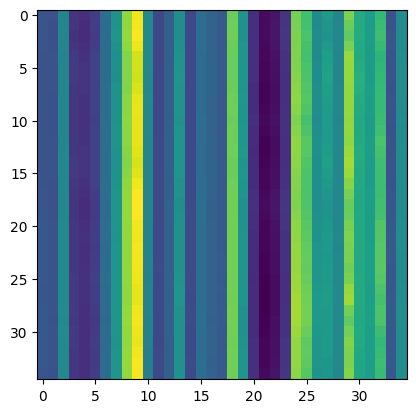

In [72]:
plt.imshow(embedding.detach().numpy())

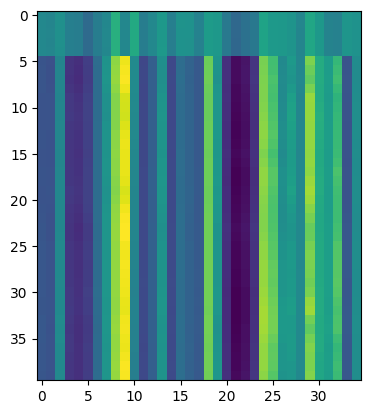

In [59]:
import matplotlib.pyplot as plt
plt.imshow(embedding.detach().numpy())

In [81]:
def check_size(x, original_file_indx):

    # Step 1: Identify NaN values
    nan_mask = torch.isnan(x)

    # Step 2: Apply the mask
    non_nan_matrix = ~nan_mask

    # Step 3: Sum along rows
    non_nan_counts = torch.sum(non_nan_matrix, dim=1)

    # Step 4: Count non-zero sums
    non_nan_row_count = torch.count_nonzero(non_nan_counts).item()

    df = pd.read_csv(f'../data/long/{original_file_indx}.csv')
    num_comp = df.shape[0]

    if non_nan_row_count != num_comp:
        print(f'original_file_indx: {original_file_indx}, and indx: {indx} are incompatible')

    return None

In [36]:
import pandas as pd 
df = pd.read_csv(f'../data/long/{original_file_indx}.csv')
df.shape[0]

38

In [6]:
import os
import json
import torch
import torch.nn as nn
from datasets import MVTSDataset
from models import TransformerEncoder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [7]:
model = TransformerEncoder(feat_dim=35,
                           max_len=40,
                           d_model=35,
                           n_heads=7,
                           num_layers=1,
                           dim_feedforward=256,
                           dropout=0.1,
                           freeze=False).float()

In [8]:
inputs = torch.randn(1, 40, 35)
mask = torch.ones(1, 40).bool()
outputs, imbedding = model(inputs, mask)

In [9]:
outputs.shape, imbedding.shape

(torch.Size([1, 40, 35]), torch.Size([1, 40, 35]))

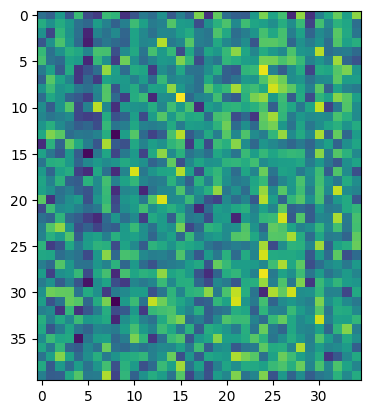

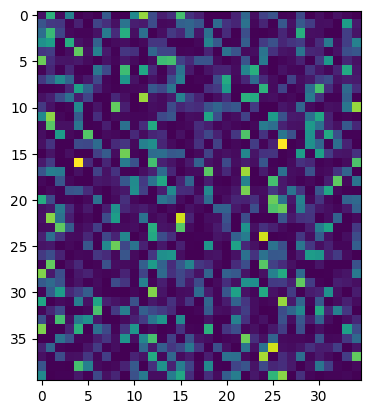

In [13]:
plt.imshow(outputs.detach().numpy()[0])
plt.show()

plt.imshow(imbedding.detach().numpy()[0])
plt.show()